In [9]:
import numpy as np
import pandas as pd
import requests
import io
from scipy import optimize
import matplotlib.pyplot as plt
import requests, pandas as pd
from bs4 import BeautifulSoup
import urllib.request
import et_xmlfile as et
import json

In [3]:
data = 'https://raw.githubusercontent.com/107SBakst/107SBakst.github.io/main/data/Emission_city_density_dataset.csv'


In [4]:
dataset = pd.read_csv(data, encoding= 'unicode_escape',error_bad_lines=False)
df = pd.DataFrame(dataset)
df

,Urban_Cluster,Country,Population,Footprint (Mt CO2),1StdDev,Footprint_per_capita_(t CO2_cap),Error (plus minus),ClusterID,Global ranking,population_density_by_city_Entity,population_density_by_city_Code,population_density_by_city_Year,population_density_by_city_Population_density_by_city
0,Hong Kong SAR,China,6029000,NaN,37.8,34.6,6.3,13847,1,Hong Kong,HKG,2011.0,25700.0
1,Mohammed Bin Zayed City,UAE,188000,NaN,5.3,32.9,27.9,5292,2,NaN,NaN,NaN,NaN
2,Abu Dhabi,UAE,911000,NaN,15.6,32.9,17.1,5288,3,NaN,NaN,NaN,NaN
3,Country of Singapore,Singapore,5235000,NaN,34.1,30.8,6.5,13845,4,NaN,NaN,NaN,NaN
4,Hulun Buir,China,198000,NaN,6.4,30.0,32.3,10441,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,"Unknown city at lat/lon 34.0, 51.4",Iran,237000,NaN,1.6,8.8,6.6,5171,496,NaN,NaN,NaN,NaN
504,"Unknown city at lat/lon 35.4, 116.9",China,471000,NaN,2.7,8.8,5.8,11975,497,NaN,NaN,NaN,NaN
505,"Unknown city at lat/lon 51.6, 0.6",UK,250000,NaN,1.4,8.8,5.4,1836,498,NaN,NaN,NaN,NaN
506,"Unknown city at lat/lon 38.7, 116.1",China,197000,NaN,1.6,8.8,8.0,11253,499,NaN,NaN,NaN,NaN


In [5]:
df.Population_a = [df.Population > 0]
df.Population_density_a = [df.population_density_by_city_Population_density_by_city > 0]
df.emissions_per_capita = [df['Footprint_per_capita_(t CO2_cap)'] > 0]


<ipython-input-5-a075c80ce709>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Population_a = [df.Population > 0]
<ipython-input-5-a075c80ce709>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Population_density_a = [df.population_density_by_city_Population_density_by_city > 0]
<ipython-input-5-a075c80ce709>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.emissions_per_capita = [df['Footprint_per_capita_(t CO2_cap)'] > 0]


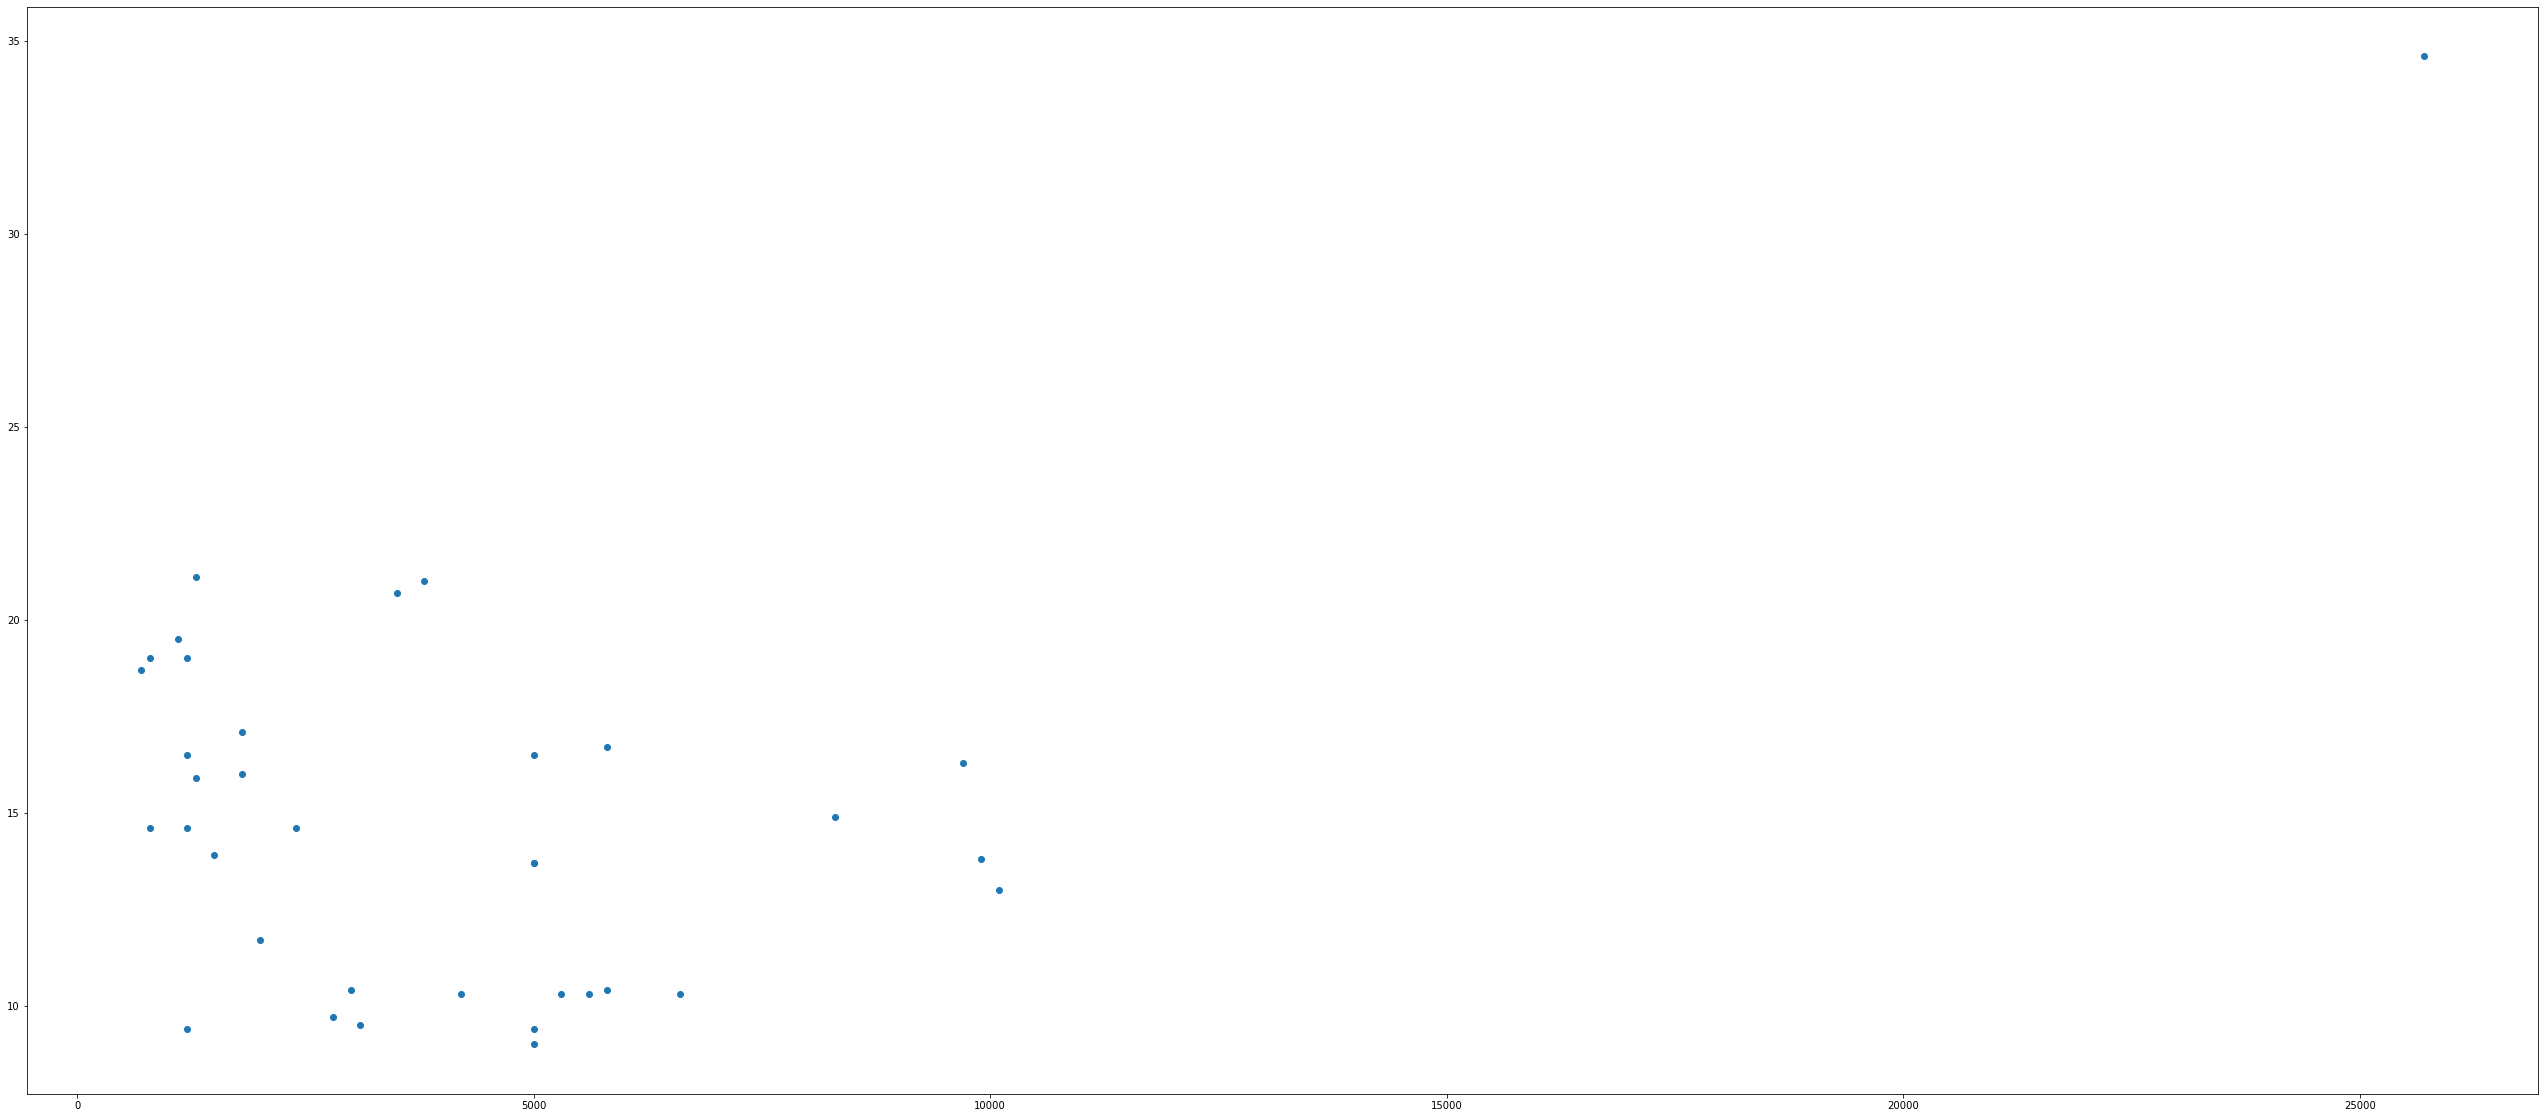

In [6]:
x = df.population_density_by_city_Population_density_by_city
y = df['Footprint_per_capita_(t CO2_cap)']
plt.figure(figsize = (45,20))
plt.scatter(x, y)

Citation: Moran, D., Kanemoto K; Jiborn, M., Wood, R., Többen, J., and Seto, K.C. (2018) Carbon footprints of 13,000 cities. Environmental Research Letters DOI: 10.1088/1748-9326/aac72a.

In [38]:
url = "https://citycarbonfootprints.info/GGMCF_top500citiesPercap.txt" # This is to get the data from the url. This file is not being saved locally.
df = pd.read_table(url) # Data is in txt file format. So read_table is needed.
df
df[['Footprint/Cap_value', 'margin']] = df['Footprint/Cap (t CO2/cap)'].str.split(' &', 1, expand=True)
df['margin'] = df['margin'].str.lstrip('plusmn;')
df['margin'].astype(float)
df['Footprint/Cap_value'].astype(float)
df['Urban Cluster'] = df['Urban Cluster'].str.replace('Country of Singapore', 'Singapore')
df['Urban Cluster'] = df['Urban Cluster'].str.replace('Hong Kong SAR', 'Hong Kong')
df['Urban Cluster'] = df['Urban Cluster'].str.replace(' ', '')
df = df.drop(columns=['Footprint (Mt CO2)', 'Footprint/Cap (t CO2/cap)'])
df


,Urban Cluster,Country,Population,1StdDev,ClusterID,Global ranking,Footprint/Cap_value,margin
0,HongKong,China,6029000,37.8,13847,1,34.6,6.3
1,MohammedBinZayedCity,UAE,188000,5.3,5292,2,32.9,27.9
2,AbuDhabi,UAE,911000,15.6,5288,3,32.9,17.1
3,Singapore,Singapore,5235000,34.1,13845,4,30.8,6.5
4,HulunBuir,China,198000,6.4,10441,5,30.0,32.3
...,...,...,...,...,...,...,...,...
495,"Unknowncityatlat/lon34.0,51.4",Iran,237000,1.6,5171,496,8.8,6.6
496,"Unknowncityatlat/lon35.4,116.9",China,471000,2.7,11975,497,8.8,5.8
497,"Unknowncityatlat/lon51.6,0.6",UK,250000,1.4,1836,498,8.8,5.4
498,"Unknowncityatlat/lon38.7,116.1",China,197000,1.6,11253,499,8.8,8.0


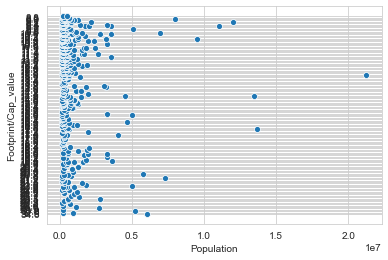

In [40]:
import seaborn as sns
sns.set_style('whitegrid')
sns.scatterplot(data=df,x='Population',y='Footprint/Cap_value')

EU GHSL - Global Human Settlement Layer data /
https://ghsl.jrc.ec.europa.eu/download.php?ds=pop

Citation: Corbane, Christina; Politis, Panagiotis; Syrris, Vasileios; Pesaresi, Martino (2018): GHS built-up grid, derived from 
Sentinel-1 (2016), R2018A. European Commission, Joint Research Centre (JRC) doi:10.2905/jrc-ghsl-10008 PID: 
http://data.europa.eu/89h/jrc-ghsl-10008

In [52]:
dens = pd.read_csv(r'C:\Users\vw191\OneDrive - University of Bristol\Course\3rd year\Data Science\Project\Datastore\eu_density_data.csv')
dfdens = pd.DataFrame(dens)
dfdens.head(1)
dfdens2 = dfdens[['ID_HDC_G0', 'CTR_MN_NM', 'CTR_MN_ISO', 'UC_NM_MN','P90', 'P00','P15', 'B15', 'BUCAP15', 'GDP15_SM', 'DEV_CMI', 'E_GR_AV14']] # These are the rows we want to keep.
# Row id, country name, country iso, city name, population in 1990, population in 2000, population in 2015, built up area in km2 in 2015, urban density, gdp in USD 2011 PPP prices, UN development level of country, average greeness located in the city in 2014 